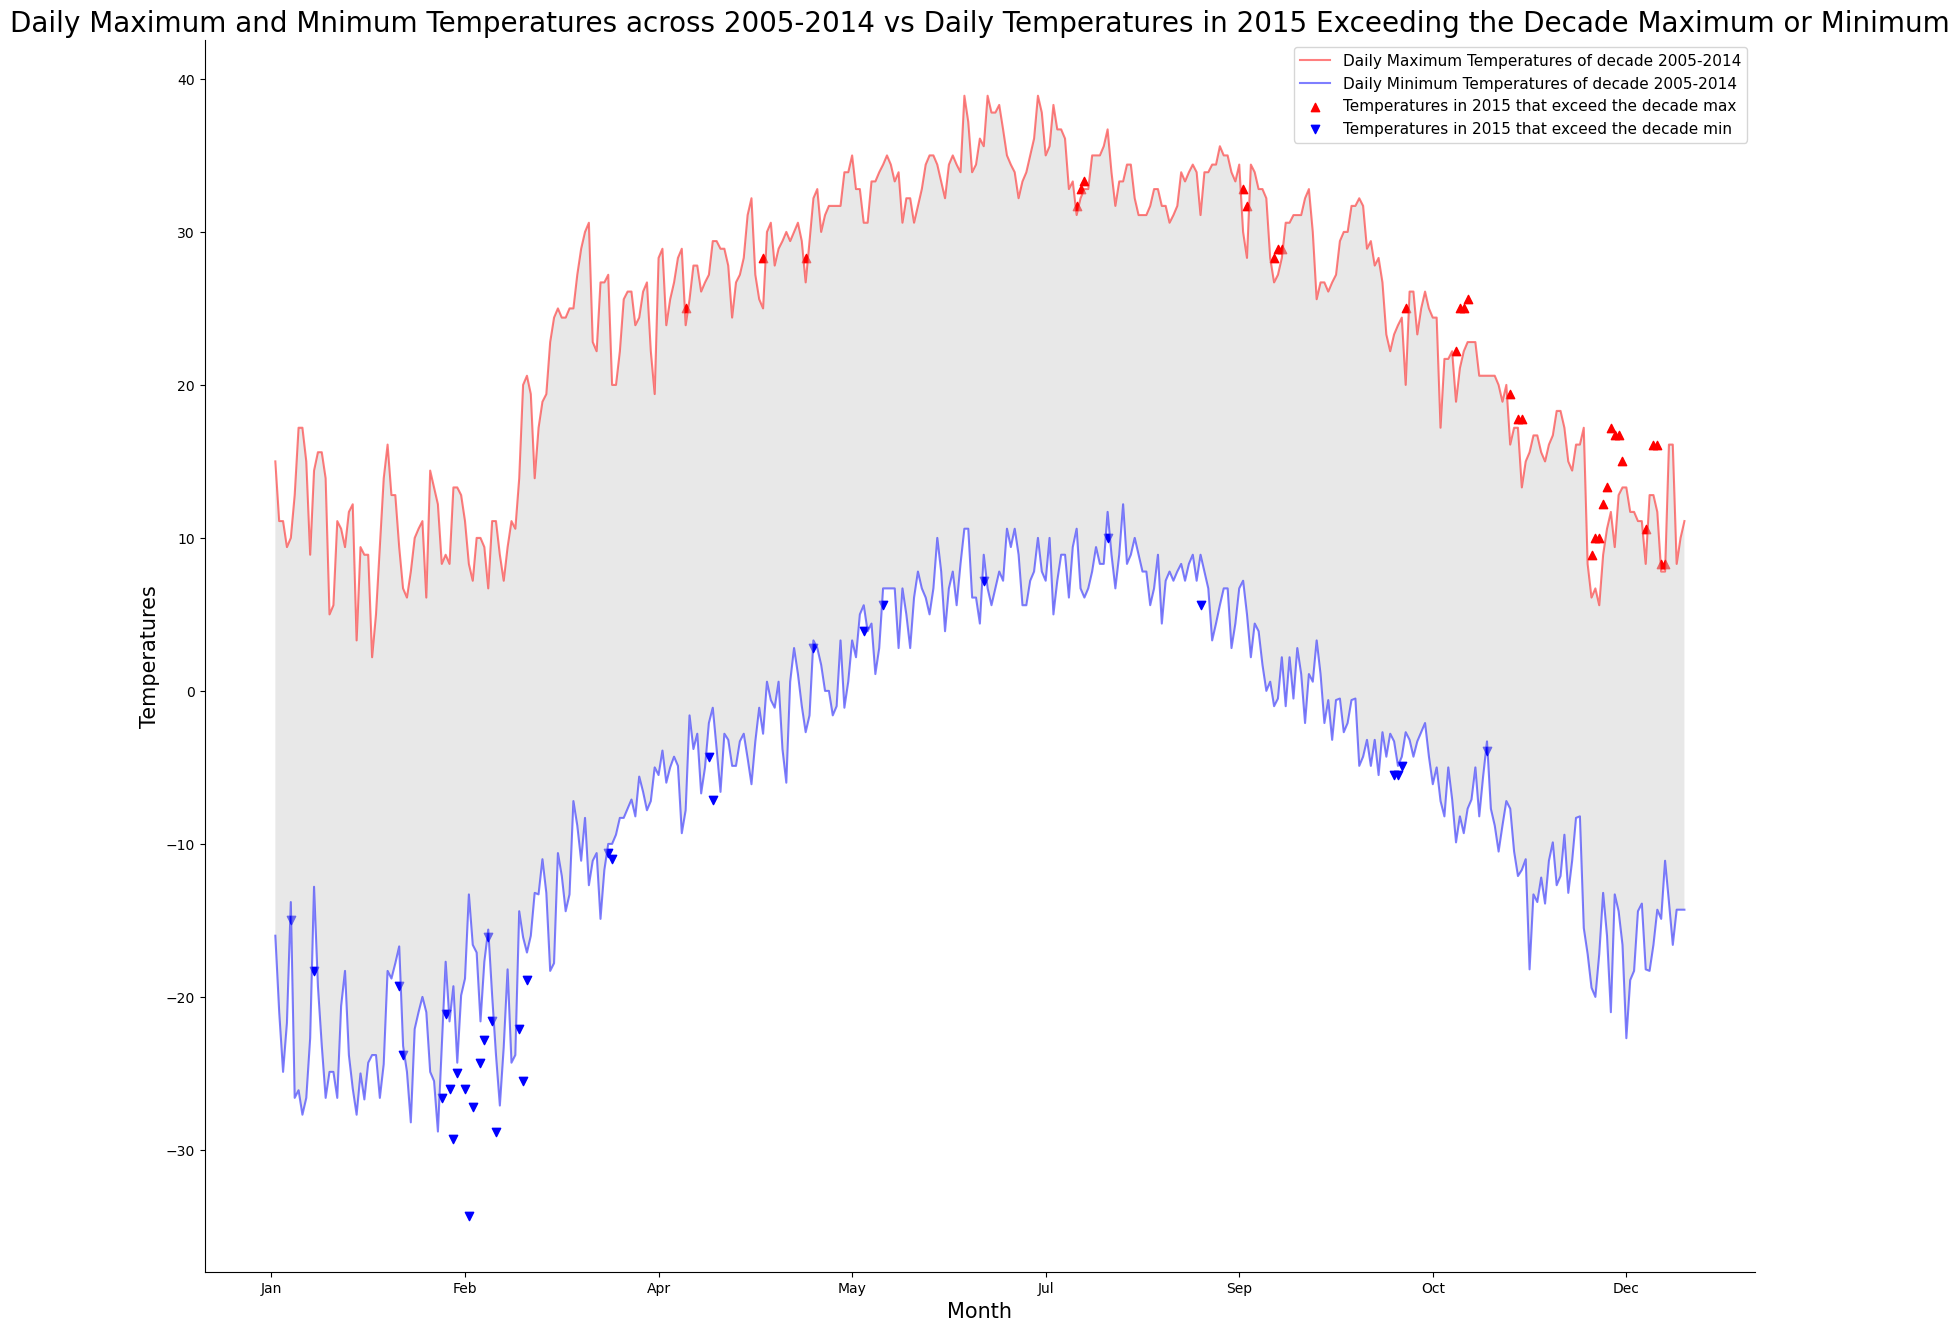

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import calendar

df = pd.read_csv('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
loc = pd.read_csv('BinSize_d400.csv')

# filter the df on the location we are interested in, Ann Arbor MI
df = pd.merge(df, loc, how = 'left', on = 'ID')
df = df[df['NAME'].str.contains('ANN')]

# clean and label columns
df = df.rename(mapper = str.strip, axis = 1)
df = df[['Date', 'Element', 'Data_Value']]
df.columns = ['Date', 'Element', 'T']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df['T'] = df['T'] * 0.1   # converting T from tenth of a Celsius to Celsius degrees
df = df[~((df.index.month == 2) & (df.index.day == 29))] # we want to eliminate the 29th of february since it will mess up the comparisons with year 2015, which is not a leap year

# creating separate series for the maximum and minimum temperatures
Tmax = df[df['Element'] == 'TMAX']
Tmin = df[df['Element'] == 'TMIN']
# since there are mutliple measurements for each given day (there are multiple weather stations for Ann Arbor), we only want to keep the max or min 
Tmax = Tmax.groupby(Tmax.index).agg(np.max) 
Tmin = Tmin.groupby(Tmin.index).agg(np.min)

# clean the two dataframes
Tmin.drop('Element', axis = 1, inplace = True)
Tmax.drop('Element', axis = 1, inplace = True)

# separate the year 2015 from the rest
Tmin_2015 = Tmin[Tmin.index.year == 2015]
Tmin = Tmin.drop(Tmin_2015.index)
Tmax_2015 = Tmax[Tmax.index.year == 2015]
Tmax = Tmax.drop(Tmax_2015.index)

# creation of dataframes containing, for each day of the year, only the max (or min) temperature of the decade for that day
Tmax = Tmax.groupby([Tmax.index.month, Tmax.index.day]).agg(np.max)
Tmax['Day'] = pd.to_datetime(Tmax.index.map(lambda x: f'{x[0]:02d}-{x[1]:02d}'), format='%m-%d') # since grouping by two columns will create a multilevel index, with the next two lines we go back to a datetime index
Tmax = Tmax.set_index('Day')
Tmin = Tmin.groupby([Tmin.index.month, Tmin.index.day]).agg(np.min)
Tmin['Day'] = pd.to_datetime(Tmin.index.map(lambda x: f'{x[0]:02d}-{x[1]:02d}'), format='%m-%d')
Tmin = Tmin.set_index('Day')

# filtering of the 2015 data, keeping only the values that are higher (or lower) than the corresponding day for the previous decade
Tmax_2015 = Tmax_2015[Tmax_2015['T'].values > Tmax['T'].values]
Tmin_2015 = Tmin_2015[Tmin_2015['T'].values < Tmin['T'].values]

# now let's plot the data
plt.figure(figsize = (20, 16))
plt.plot(Tmax.index.dayofyear, Tmax, label = 'Daily Maximum Temperatures of decade 2005-2014', c = 'r', alpha = 0.5)
plt.plot(Tmin.index.dayofyear, Tmin, label = 'Daily Minimum Temperatures of decade 2005-2014', c = 'b', alpha = 0.5)
plt.scatter(Tmax_2015.index.dayofyear, Tmax_2015, label = 'Temperatures in 2015 that exceed the decade max', c = 'r', marker = '^')
plt.scatter(Tmin_2015.index.dayofyear, Tmin_2015, label = 'Temperatures in 2015 that exceed the decade min', c = 'b', marker = 'v')
plt.fill_between(Tmax.index.dayofyear, Tmax['T'], Tmin['T'], facecolor = 'lightgray', alpha = 0.5)

# the following couple lines are necessary to change the tickers on the x axis from the day number to the abbreviated month name
months = MonthLocator(bymonthday = 15, interval = 1)
monthFmt = DateFormatter('%b')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthFmt)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer = True, prune = 'both')) # this removes the months that are not present in our data but that show up as tickers on the x axis

# removing the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# setting titles and labels
plt.title('Daily Maximum and Mnimum Temperatures across 2005-2014 vs Daily Temperatures in 2015 Exceeding the Decade Maximum or Minimum', fontsize = 20)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Temperatures', fontsize = 15)
plt.legend(fontsize = 11)

plt.show()